### Import Packages

In [25]:
# import packages, I mostly use the same packages all the time, not all of these are usefull I suppose
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.constants as const
import pandas as pd 
from scipy.optimize import curve_fit
# from scipy import stats
# from sklearn.neighbors import LocalOutlierFactor
import datetime
import fabio
import math
import random
import os
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from sys import platform 
from os.path import exists
import meera_func as mfc
# %matplotlib widget
# import ipywidgets as widgets
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6) #this is for a constant figure size

## Import data

In [26]:
#import data
path = '/Users/meera94/Desktop/LCLS MEC LX99' # Main XRD data folder
data_files = 'LX99 analysis'
xrd_data_folder_name = 'Raw_data_LX99'                   # Name of folder containing XRD run folders
calibration_folder_name = 'XRD_calibration_files'   # Name of folder containing calibration (.poni) files
energy_file_name = 'Energies.csv'

## Open and store runs

In [27]:
## opening runs from tiff files tand saving them to a dictionary. We will rotate the images as required by the detector
#Runs = [140, 143, 146]#, 149, 152, 157, 160, 163, 166, 169, 173, 176, 182, 185, 179, 237, 240, 243, 249, 252, 255, 260, 263, 270, 273, 276, 282, 285, 288, 291, 294, 297, 300, 305, 311, 313, 316, 319, 327, 330, 336, 333, 339] 
#Runs = [139, 140, 142, 143, 145, 146, 148, 149, 151, 152, 157, 159, 160, 162, 163, 165, 166, 168, 169, 172, 173, 175, 176, 178, 181, 182, 184, 185, 179, 234, 237, 239, 240, 242, 243, 248, 249, 251, 252, 254, 255, 259, 260, 262, 263, 269, 270, 272, 273, 275, 276, 281, 282, 284, 284, 285, 287, 288, 290, 291, 293, 294, 296, 297, 299, 300, 302, 304, 305, 307, 310, 311, 312, 313, 315, 316, 318, 319, 326, 327, 329,  330, 335,  336, 332, 333, 338, 339] 
Runs = [140, 143]
Quads = [0, 1, 2, 3]
Run_key_list= [] #empty key list which will be used to create our dictonary, gonna make this a string
Quad_key_list= []
for j in Runs:
    keys = 'Run ' + str(j) 
    Run_key_list.append(keys) #so now we have a string of keys that we want
    # j = j + 1
    
for i in Quads:
    keys = 'Quad' + str((i))
    Quad_key_list.append(keys) #so now we have a string of keys that we want
    # i = i +1

Run_images = dict.fromkeys(Run_key_list) # this stores all the runs listed above. Dictionary with keys ready for our data now!
# Quad_images = dict.fromkeys(Quad_key_list) # this stores all the images from all the quads.
rot_mat = [-1, 1, 0, 1]  # The MEC detectors have tilts and rotations associated with it. Since they are all some factor of 90 we will use the numpy rotate 90 function and usin 1,0,-1 to determin
rot_angles = ["-90", "+90", "0", "+90"]

for j in Runs:
    # images_all_quads = []
    Quad_images = dict.fromkeys(Quad_key_list) # this stores all the images from all the quads.
    for i in Quads:
        name_image = '/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/scratch/run' + str(j) + '/Run_' + str(j) + '_evt_1_Epix10kaQuad' + str(i)+ '.tiff'
        images = np.rot90(np.flipud(fabio.open(name_image).data), rot_mat[i]) #fabio.open(name_image).data #apparently we need to flip up to down Rahul said. I asked why, he said try without flipping and then you will see. \../
        Quad_images['Quad' + str((i))] = images #dictionary with all the quads for each run
        # i = i + 1
    Run_images['Run ' + str(j)] = Quad_images # adding the data to the appropriate keys. Final dictionary with all the runs and quads
    # j = j + 1


## Energy import (My Rahul <3 & Rahul Saha code)

In [32]:
#Read energies in KeV
if platform == "linux" or platform == "linux2":
    concat_3 = "{0}/{1}/{2}"
    concat_2 = "{0}/{1}" ### this is to precudurally generate a path for your platform type (i.e linux in this line) to your directory. I would never use something so uneccesarily complicated cos I am not a CS major. What a fucking pain
elif platform == "darwin": # apparently darwin is mac. 
    concat_3 = "{0}/{1}/{2}"
    concat_2 = "{0}/{1}"
elif platform == "win64":
    concat_3 = "{0}\\{1}\\{2}"
    concat_2 = "{0}\\{1}"
else:
    concat_3 = "{0}\\{1}\\{2}"
    concat_2 = "{0}\\{1}"

In [31]:
# Read Gas Norms
def read_gas_norms(Runs, default_gas_norm = 0.7):
    import warnings
    run_numbers_list = ['run'+ str(number) for number in Runs]
    print(run_numbers_list)
    gas_norm_values = {} # Dict containing all gas_norm values
    # Make a list of paths of all .txt files
    for run in run_numbers_list:
        gas_norm_values[run] = {'event':[], 'value':[]}
        text_file_name = concat_2.format(run, run + '_Bld.txt')
        text_file_path = concat_3.format(path, xrd_data_folder_name, text_file_name)
        header_bool = True
        
        print(text_file_path)
        #if text_file_path
        try:
            data = open(text_file_path)
            event_counter = 0
            for dat in data:
                if header_bool == True:
                    header_bool = False
                else:
                    gas_norm_values[run]['event'].append(event_counter)
                    try:
                        gas_norm_values[run]['value'].append(float(dat.split(' ')[1]))
                    except:
                        warnings.warn(run + " has no value for gas norm, set to " + str(default_gas_norm) + " by default.")
                        gas_norm_values[run]['value'].append(float(default_gas_norm))
                event_counter += 1
        except:
            warnings.warn(run + " has no .txt file. Values set to defaults.")
            gas_norm_values[run]['event'] = [1]
            gas_norm_values[run]['value'] = [default_gas_norm]         

    # Remove negative and non-positive value for gas norm energies
    # Raise warnings and exceptions in such edge cases
    ref_run_bool = True
    for runs in gas_norm_values:
        if ref_run_bool == True: 
            ref_run_bool = False
            old_events = gas_norm_values[runs]['event']
            old_values = gas_norm_values[runs]['value']
            nan_idx = [idx for idx, val in enumerate(old_values) if np.isnan(val) == True]
            neg_idx = [idx for idx, val in enumerate(old_values) if val <= 0]
            remove_idx = nan_idx + neg_idx
            new_events = [evt for idx, evt in enumerate(old_events) if idx not in remove_idx]
            new_values = [val for idx, val in enumerate(old_values) if idx not in remove_idx]
            # Warn if there are multiple values
            if len(nan_idx) > 1: warnings.warn("There are" + str(len(nan_idx)) + "nan values in " + runs)
            elif len(new_values) == 0: raise Exception(runs + "contains only nan/ non-positive gas norm energy values!")
            gas_norm_values[runs]['event'] = new_events
            gas_norm_values[runs]['value'] = new_values
        else:
            if np.isnan(gas_norm_values[runs]['value'][0]) == True:
                gas_norm_values[runs]['value'][0] = default_gas_norm
                #raise Exception(runs + " has an nan gas norm energy value.")
            elif gas_norm_values[runs]['value'][0] <= 0:
                gas_norm_values[runs]['value'][0] = default_gas_norm
                #raise Exception(runs + " has an zero or negative gas norm energy value.")

    # Calculate the appropriate event for the reference
    shot_value = gas_norm_values[run_numbers_list[1]]['value'][0]
    diffs = [np.abs(val - shot_value) for val in gas_norm_values[run_numbers_list[0]]['value']]
    ref_event_idx = np.argmin(diffs)
    ref_event = gas_norm_values[run_numbers_list[0]]['event'][ref_event_idx]

    # Compile list of gas norm values
    gas_norms = []
    ref_run_bool = True
    for runs in gas_norm_values: 
        if ref_run_bool == True:
            gas_norms.append(gas_norm_values[runs]['value'][ref_event_idx])
            ref_run_bool = False
        else:
            gas_norms.append(gas_norm_values[runs]['value'][0])
    return gas_norms, ref_event



In [16]:
    
def read_energies(energy_file_name, run_numbers):
    file = open(energy_file_name)
    header_bool = False
    energies = []
    for data in file:
        if header_bool == False:
            header_bool = True
        elif int(data.split(',')[0]) in run_numbers:
            energies.append(float(data.split(',')[1]))
    return energies

energy_file_path = concat_2.format(path, energy_file_name)
E = read_energies(energy_file_path, Runs)
print("Energies (eV): ", E)

Gas_norm, ref_evt = read_gas_norms(Runs)
ref_evt_string = 'evt_' + str(int(ref_evt)) + '_'

print("Gas norms: ", Gas_norm)
print("Reference event: ", ref_evt, " of ", type(ref_evt))

# Convert energy (eV) to wavelength (m)
def get_wavelengths(E):
    lams = []
    h = const.h # Planck's constant in Js
    c = const.c # Speed of light in m/s
    e = const.e # Electron charge in Coulomb
    # E in eV
    return [h*c/(e*energy) for energy in E]
lams = get_wavelengths(E)
print("Wavelengths (m): ", lams)



Energies (eV):  [17200.7, 17200.7]
['run140', 'run143']
/Users/meera94/Desktop/LCLS MEC LX99/Raw_data_LX99/run140/run140_Bld.txt
/Users/meera94/Desktop/LCLS MEC LX99/Raw_data_LX99/run143/run143_Bld.txt
Gas norms:  [1.00453, 1.10737]
Reference event:  7  of  <class 'int'>
Wavelengths (m):  [7.208090277325937e-11, 7.208090277325937e-11]


## Plotting the runs

In [18]:
read_gas_norms([140], default_gas_norm = 0.7)

['run140']
/Users/meera94/Desktop/LCLS MEC LX99/Raw_data_LX99/run140/run140_Bld.txt


IndexError: list index out of range

In [17]:
'/users/meera94/Desktop/LCLS MEC LX99/Raw_data/run140/run140_Bld.txt'
'/Users/meera94/Desktop/LCLS MEC LX99/Raw_data_LX99/run143/run143_Bld.txt'
print(ref_evt_string)

evt_7_


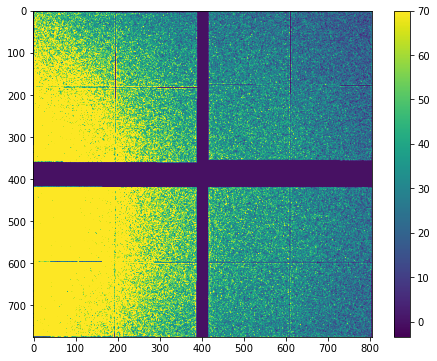

In [28]:
#plotting the quads we want. Princess is always so meow meow about plotting things moew. 
Run = 140
quad_2_plot = 3
plt.imshow(Run_images['Run ' +str(Run)] ['Quad' + str(quad_2_plot)], vmax = 70)
plt.colorbar()

## Opening the calibration files

In [29]:
#open the calibration files. Using the same method as above, I am putting all the calibration files in an empty dictionary.
calibration = "/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/analysis/XRD_calibration_files/"
Quads = [0, 1, 2, 3]
calib_keys = []
for i in Quads:
    keys = 'Calib' + ' Quad' + str((i))
    calib_keys.append(keys) #so now we have a string of keys that we want
    # i = i +1
calib_all = dict.fromkeys(calib_keys)   

for i in Quads:
    calib = pyFAI.load (calibration + 'Quad'+ str(i) + '.poni')
    calib_all['Calib' + ' Quad' + str((i))] = calib
    # i = i + 1

### 1D Azimuthal Intergration Sanity check

In [30]:
name_image = name_image = '/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/scratch/run140/Run_140_evt_1_Epix10kaQuad0.tiff'
images = np.rot90(np.flipud(fabio.open(name_image).data), rot_mat[0])

In [31]:
range(3, np.shape(images)[1]-3)

range(3, 776)

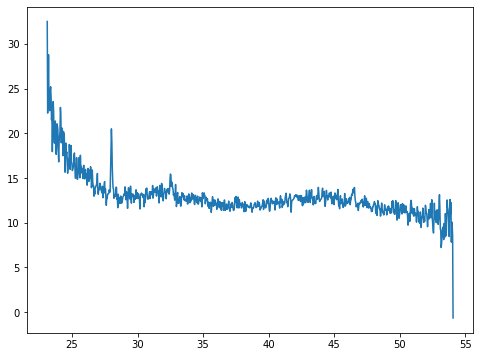

In [32]:
## Azimuthal integration
# mask_1 = images!=0.0 # masks out the low pixels(=0) (areas between the modules)
def line_mask(x, m = 4.8, c = 345):
    y = m*x+c
    return y

mask_1 = images!=0.0 # masks out the low pixels(=0) (areas between the modules) here we care about the c values or the intensity
mask_2 = images<500 ## masks out the hot pixels (>500) (areas between the modules)

# x = np.linspace(0, 100, 100)
# mask_3 = images<line_mask(x)
edge_mask_width = 3

mask_tri = np.full(np.shape(images), True)
for i in range(edge_mask_width, np.shape(images)[0]-edge_mask_width):
    for j in range(edge_mask_width, np.shape(images)[1]-edge_mask_width):
        # print([i, j])
        if i >= line_mask(j):
            mask_tri[i, j] = True
        else:
            mask_tri[i, j] = False
mask_tri = np.logical_not(mask_tri)

mask = mask_1 & mask_2 & mask_tri
mask = mask.astype('float')
mask[mask == 0] = np.nan
Integ_results = calib_all['Calib Quad0'].integrate1d(images*mask, 1000)

x = Integ_results[0]
y = Integ_results[1]
y[y == 0] = np.nan

plt.plot(x, y)

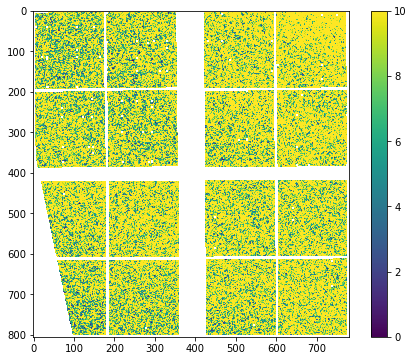

In [33]:


#plotting the masks used
# plt.imshow(mask)
# plt.colorbar()
# plt.show()
# plt.imshow(mask_2)
# plt.colorbar()
# plt.show()
plt.imshow(images*mask, vmax=10, vmin=0)
plt.colorbar()
plt.show()


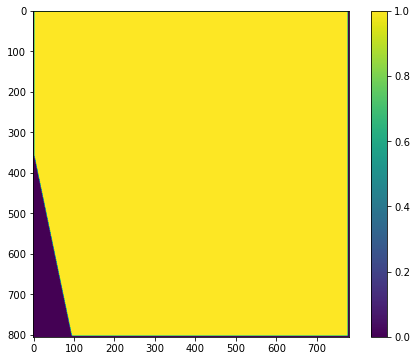

In [34]:
#plotting the masks used
plt.imshow((mask_tri))
plt.colorbar()
plt.show()

# 1D Azimuthal Intergration

In [35]:
## Azimuthal integration
Int_keys = []
Int_quad_keys = []
for j in Runs:
   keys = 'Run ' + str((j))
   Int_keys.append(keys)
Int_1D_results = dict.fromkeys(Int_keys) 

for i in Quads:
   keys = 'Quad' + str((i))
   Int_quad_keys.append(keys)

counter = 0
   
for j in Runs:
   Int_1D_quads = dict.fromkeys(Int_quad_keys)
   for i in Quads:
      img = Run_images['Run ' + str(j)]['Quad'+ str(i)]
      mask_1 = Run_images['Run ' + str(j)]['Quad'+ str(i)] != 0.0 # masks out the low pixels(<1) (areas between the modules)
      mask_2 = Run_images['Run ' + str(j)]['Quad'+ str(i)] < 500 ## masks out the hot pixels (>500) (areas between the modules)
      mask_edge = np.full(np.shape(img), True)
      mask_edge[0:3, :] = False
      mask_edge[-4:-1, :] = False
      mask_edge[:, 0:3] = False
      mask_edge[:, -4:-1] = False
      
      if i == 0:
         mask = mask_1 & mask_2 & mask_tri
      else:
         mask = mask_1 & mask_2 & mask_edge
      mask = mask.astype('float')
      mask[mask == 0] = np.nan
      calib_all['Calib Quad' + str(i)].wavelength = lams[counter]
      Integ_results = calib_all['Calib Quad' + str(i)].integrate1d(img*mask, 2000, unit="2th_deg") # remember to put 
      Integ_results[1][Integ_results[1] == 0] = np.nan
      
      Int_1D_quads['Quad' + str((i))] =  Integ_results
   Int_1D_results['Run ' + str((j))] = Int_1D_quads
   counter = counter + 1
      
#print(Int_1D_results)

## Plotting all the Runs

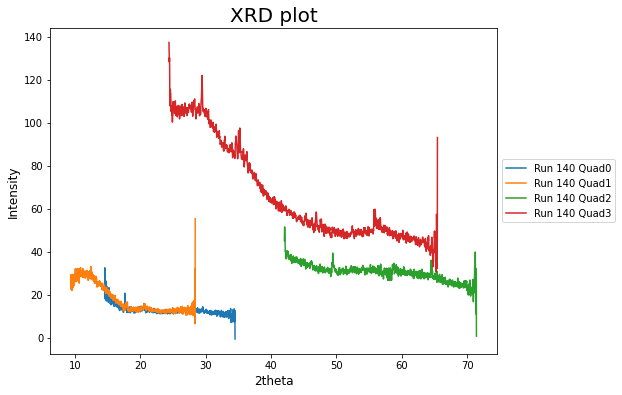

In [36]:
# plotting intergrated results for any Run and all quads
clr = ['purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink'] 
for i in range(len(Runs)): 
    for j in Quads:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]
        plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j)) 
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('2theta', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# max(Integresults[1])

# Peak fitting

[12.09078549 50.          8.86112722  3.26708844]


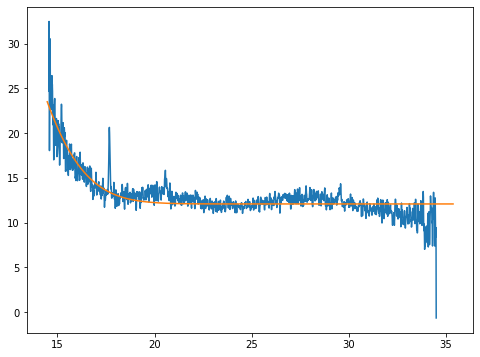

[12.86260722 16.70043245 11.41743201  3.        ]


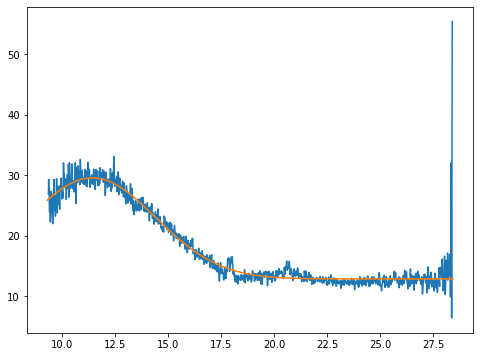

[26.10661169 24.61605769 17.         20.        ]


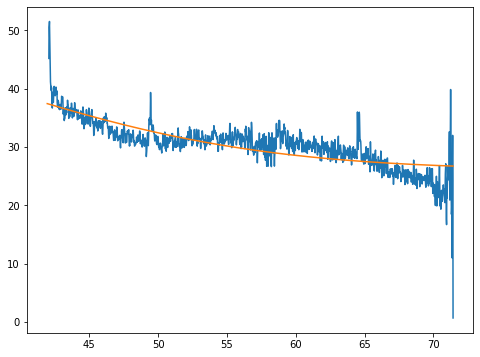

[44.99139094 81.79253765 17.         14.29303867]


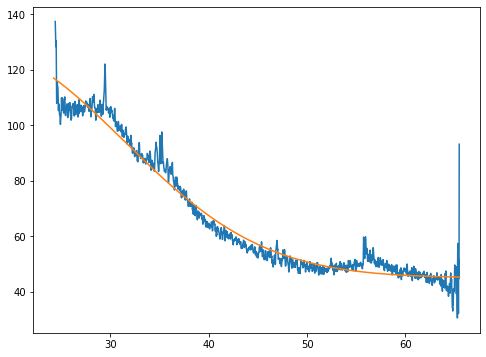

In [37]:
#fitting a gaussian fit? How does one fit a curve? 
#step 1: Define a peak fitting function. This can be any function you want, just write down the function with all the defining parameters. Pro tip: Plot the function on desmos and see how each fitting parameter affects the curve fit to understand your function better
#step 2: use Scipy optimize curve fit library and it will help you fit your curve. You can use any bounds you want and any initial parameters you want and you can ask for least square method(thats the default) where it will try to minimize the square of the distance from your point outside the curve to the curve :) 
# You are now ready to do this biatch!
#Define the Gaussian function
def gaussfit(x, B, a, x0, sigma):
    return B + a*np.exp(-(x-x0)**2/(2*sigma**2))

# Quad 0
p0 = np.array([15, 30, 11, 7])
B_low = np.array([0, 5, 5, 3])
B_high = np.array([50, 50, 17, 20])
Bounds = (B_low,B_high)
x = Int_1D_results['Run ' + str(Runs[i])]['Quad0'][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad0'][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(gaussfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad0'][0],Int_1D_results['Run ' +str(Runs[i])]['Quad0' ][1])
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad0'][0], gaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad0'][0], *popt))
plt.show()

# Quad 1
#initial guesses and bounds for the fit
p0 = np.array([15, 30, 11, 7])
B_low = np.array([0, 5, 5, 3])
B_high = np.array([50, 50, 17, 20])
Bounds = (B_low,B_high)
x = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(gaussfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0],Int_1D_results['Run ' +str(Runs[i])]['Quad1' ][1])
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0], gaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0], *popt))
plt.show()

# Quad 2
p0 = np.array([15, 30, 11, 7])
B_low = np.array([0, 5, 5, 3])
B_high = np.array([50, 50, 17, 20])
Bounds = (B_low,B_high)
x = Int_1D_results['Run ' + str(Runs[i])]['Quad2'][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad2'][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(gaussfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad2'][0],Int_1D_results['Run ' +str(Runs[i])]['Quad2' ][1])
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad2'][0], gaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad2'][0], *popt))
plt.show()

# Quad 3
p0 = np.array([15, 30, 11, 7])
B_low = np.array([0, 5, 5, 3])
B_high = np.array([100, 100, 17, 20])
Bounds = (B_low,B_high)
x = Int_1D_results['Run ' + str(Runs[i])]['Quad3'][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad3'][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(gaussfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad3'][0],Int_1D_results['Run ' +str(Runs[i])]['Quad3' ][1])
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad3'][0], gaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad3'][0], *popt))
plt.show()


# Extra Stuff for Checking if we want to offset or scale?

### Offset or scaling?

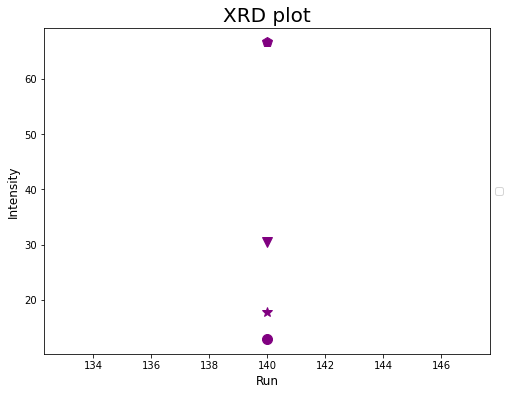

In [17]:
# plotting the mean of each against the run numbers
Run = [140]
clr = ['purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink'] 
sym = ['o', '*', 'v', 'p'] 
for i in range (len(Runs)): 
    for j in Quads:
        plt.plot (Runs[i], np.nanmean(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]), sym[j], markersize = 10, color = clr[i], linestyle = 'dashed') #, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j) ) #color = clr[j])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('Run', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

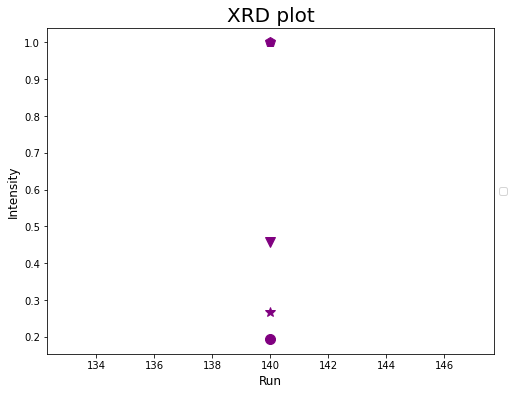

In [18]:
## plotting each quad divided by Quad 3
# plotting the mean of each against the run numbers
# color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
# clr = [random.choice(color) for i in range(50)]
clr = ['purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink'] 
sym = ['o', '*', 'v', 'p'] 
for i in range (len(Runs)): 
    for j in Quads:
        plt.plot (Runs[i], (np.nanmean(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]))/(np.nanmean(Int_1D_results['Run ' + str(Runs[i])]['Quad3'][1])), sym[j], color = clr[i], markersize = 10) #,  label = 'Run ' + str(Runs[i]) + ' Quad' + str(j) + '/ Run ' +  str(Runs[i]) + ' Quad3') #color = clr[j])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('Run', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Quad stitching